In [1]:
import numpy as np
import cv2
from random import randint
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from random import choice, sample
import seaborn as sns

# Setting up the style using seaborn
sns.set_context("paper", font_scale=1, rc={"axes.linewidth": 1.5})

orig_input_shape=(128, 128, 1)
target_input_shape=(123, 123, 1)

def rotate(image):
    """
    Rotates an image clockwise or anticlockwise.
    :param image: np.array, the input image.
    :param clockwise: bool, True for clockwise rotation, False for anticlockwise.
    :param magnitude: int, a value from 1 to 10 to determine the angle of rotation.
    :return: np.array, the rotated image.
    """
    image = image.copy()
    rows, cols = image.shape[:2]
    #angle = np.random.randint(1 + 36*(magnitude-1), 36*magnitude)
    angle = choice([90, 180, 270])
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

def vertical_flip(image):
    """
    Flips an image vertically or horizontally.
    :param image: np.array, the input image.
    :param vertical: bool, True for vertical flip, False for horizontal flip.
    :return: np.array, the flipped image.
    """
    image = image.copy()
    flip_direction = 0
    return cv2.flip(image, flip_direction)

def horizontal_flip(image):
    """
    Flips an image vertically or horizontally.
    :param image: np.array, the input image.
    :param vertical: bool, True for vertical flip, False for horizontal flip.
    :return: np.array, the flipped image.
    """
    image = image.copy()
    flip_direction = 1
    return cv2.flip(image, flip_direction)

def translate(image):
    """
    Translates an image vertically, horizontally or both.
    :param image: np.array, the input image.
    :param magnitude: int, a value from 1 to 10 to determine the pixels of translation.
    :return: np.array, the translated image.
    """
    translation_choice = choice([0, 1, 2])  # 0 for vertical, 1 for horizontal, 2 for both
    magnitude1 = 5
    magnitude1 = magnitude1 * choice([-1, 1])
    magnitude2 = 0
    magnitude2 = magnitude2 * choice([-1, 1])
    image = image.copy()
    rows, cols = image.shape[:2]

    if translation_choice == 0:  # Vertical translation
        M = np.float32([[1, 0, 0], [0, 1, magnitude1]])
    elif translation_choice == 1:  # Horizontal translation
        M = np.float32([[1, 0, magnitude2], [0, 1, 0]])
    else:  # Both translations
        M = np.float32([[1, 0, magnitude2], [0, 1, magnitude1]])  # Applying both translations

    return cv2.warpAffine(image, M, (cols, rows))

def random_erasing(image):
    """
    Randomly erases a vertical or horizontal column of the image.
    :param image: np.array, the input image.
    :param vertical: bool, True for vertical column, False for horizontal column.
    :param magnitude: int, a value from 1 to 10 to determine the width of the column.
    :return: np.array, the image with a column erased.
    """
    erasing_choice = 1
    magnitude1 = 2
    magnitude2 = np.random.randint(0, 5)

    if erasing_choice == 0:
        rows, cols = image.shape
        start_col = randint(0, cols - magnitude1)
        image[:, start_col:start_col + magnitude1] = np.random.randint(256, size=(rows, magnitude1))
        return image
    elif erasing_choice == 1:
        rows, cols = image.shape
        start_row = randint(0, rows - magnitude2)
        image[start_row:start_row + magnitude2, :] = np.random.randint(256, size=(magnitude2, cols))
        return image
    else:
        rows, cols = image.shape
        start_col = randint(0, cols - magnitude1)
        image[:, start_col:start_col + magnitude1] = np.random.randint(256, size=(rows, magnitude1))
        start_row = randint(0, rows - magnitude2)
        image[start_row:start_row + magnitude2, :] = np.random.randint(256, size=(magnitude2, cols))
        return image

augment_funcs = {
    'rotate': rotate,
    'translate': translate,
    'vertical_flip': vertical_flip,
    'horizontal_flip': horizontal_flip,
    'random_erasing': random_erasing,
    'identity': lambda x: x,
}

In [2]:
def normalize_to_range(arr, lower_bound=0, upper_bound=255):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    # Normalize to [0, 1]
    normalized = (arr - arr_min) / (arr_max - arr_min + 1e-7)
    # Scale to [lower_bound, upper_bound]
    scaled = normalized * (upper_bound - lower_bound) + lower_bound
    return scaled

def crop(array, crop=target_input_shape[0]):
    center = np.array(array.shape) / 2
    x1, y1 = center - crop//2
    x2, y2 = center + crop//2
    cropped_array = array[int(x1):int(x2), int(y1):int(y2)]
    return cropped_array

def load_nc(func_name, magnitude=5):
    with xr.open_dataset('cropped.nc') as data:
        irwin = data['irwin_cdr'].values[0]
        irwin = normalize_to_range(irwin)
        augment_func = augment_funcs[func_name]
        augmented = augment_func(irwin, magnitude)
        irwin = crop(augmented)
    return irwin

def load_nc_augment():
    N = np.random.randint(1, len(list(augment_funcs.keys())))
    funcs = sample(list(augment_funcs.keys()), N)
    with xr.open_dataset('cropped.nc') as data:
        irwin = data['irwin_cdr'].values[0]
        irwin = normalize_to_range(irwin)
        augmented = irwin.copy()
        for func_name in funcs:
            augment_func = augment_funcs[func_name]
            augmented = augment_func(augmented)
        augmented = crop(augmented)
    return augmented

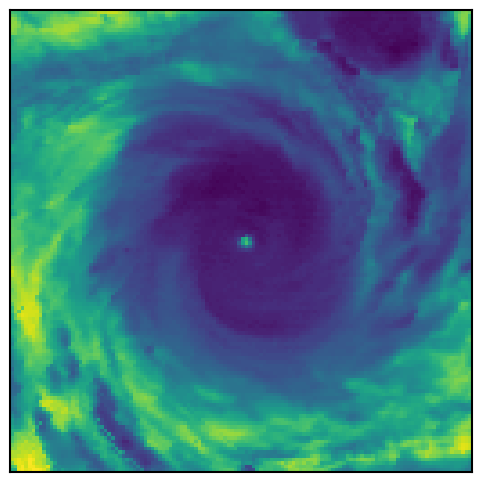

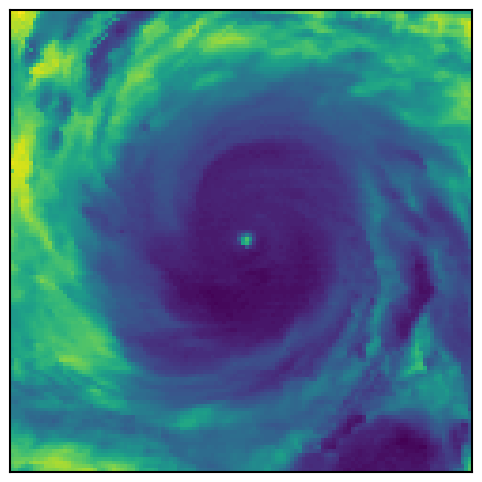

In [3]:
with xr.open_dataset('data/gridsat_cropped/GRIDSAT.57710.nc') as data:
    irwin = data['irwin_cdr'].values[0]
    irwin = normalize_to_range(irwin)
    augmented = irwin.copy()
augmented = random_erasing(augmented)
augmented = crop(augmented)
plt.figure(figsize = (8,6)) 
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
plt.imshow(irwin)
plt.show()

with xr.open_dataset('data/gridsat_cropped/GRIDSAT.57710.nc') as data:
    irwin = data['irwin_cdr'].values[0]
    irwin = normalize_to_range(irwin)
    augmented = irwin.copy()
augmented = vertical_flip(augmented)
augmented = crop(augmented)
plt.figure(figsize = (8,6)) 
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
plt.imshow(augmented)
plt.show()

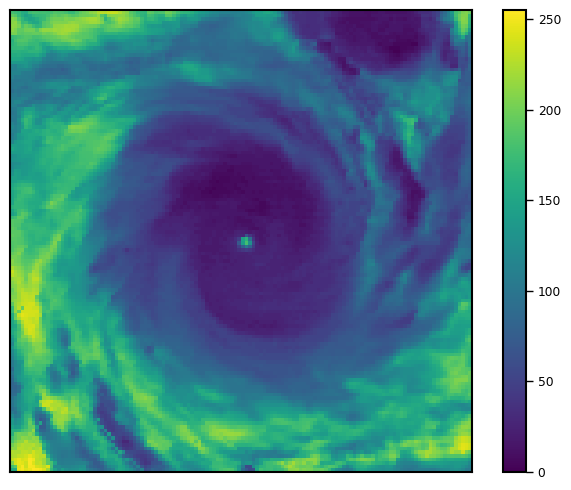

In [5]:
with xr.open_dataset('data/gridsat_cropped/GRIDSAT.57710.nc') as data:
    irwin = data['irwin_cdr'].values[0]
    irwin = normalize_to_range(irwin)
    augmented = irwin.copy()
augmented = random_erasing(augmented)
augmented = crop(augmented)
plt.figure(figsize = (8,6)) 
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
plt.imshow(irwin)
plt.colorbar()
plt.show()